<div style="text-align: right">Update date: Mar 25, 2024</div><br>


# Risk scoring<br>
## Data preparation<br>

### Objetive<br>
Prepare the data to develop 3 machine learning models that allow projecting the expected loss (EL) when providing a bank loan, and thus, assess the risk before granting it to the client, based on historical loans to 200,000 clients.
<br><br>

### The general outline of this notebook is as follows:<br>

    1. Imports and adjustments
    2. Load data
    3. Reserve the validation dataset
    4. Data quality
    5. Exploratory data analysis
    6. Transform variables
    7. Save training dataset
    
    
<br>

### Main work tools<br>


|Package|                           Version|
|:---------------------------------|--------:|
|matplotlib                        |3.8.0|
|numpy                             | 1.26.4|
|notebook                          |6.5.4|
|pandas                            | 2.2.1|
|python                            |3.12.2|
|sklearn                           |1.3.0|

### Imports and adjustments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
%config IPCompleter.greedy = True

pd.options.display.float_format = '{:,.2f}'.format

### Load data

In [2]:
loans = pd.read_csv('../data/original/prestamos.csv')
print(f'{loans.shape=}')
loans.head()

loans.shape=(200000, 25)


,id_cliente,empleo,antigüedad_empleo,ingresos,ingresos_verificados,rating,dti,vivienda,num_hipotecas,num_lineas_credito,...,id_prestamo,descripcion,finalidad,principal,tipo_interes,num_cuotas,imp_cuota,imp_amortizado,estado,imp_recuperado
0,137387967,Hvac technician,3 years,"54,000.00",Source Verified,A,19.31,MORTGAGE,2.00,10.00,...,NaN,NaN,debt_consolidation,"15,000.00",7.21,36 months,464.60,"2,669.06",Current,0.00
1,4798121,"Target Promotions and Marketing,Inc",10+ years,"65,000.00",Not Verified,D,25.40,RENT,1.00,15.00,...,NaN,NaN,debt_consolidation,"10,000.00",17.77,36 months,360.38,"6,362.96",Charged Off,0.00
2,46641215,Banker,5 years,"135,000.00",Verified,A,14.68,RENT,0.00,19.00,...,NaN,NaN,debt_consolidation,"24,000.00",6.39,36 months,734.38,"24,000.00",Fully Paid,0.00
3,87998444,executive director,9 years,"188,000.00",Source Verified,B,11.69,MORTGAGE,3.00,15.00,...,NaN,NaN,credit_card,"27,000.00",8.99,60 months,560.35,"12,443.00",Current,0.00
4,132883631,Subsea Technician,7 years,"125,000.00",Source Verified,B,9.00,MORTGAGE,1.00,6.00,...,NaN,NaN,debt_consolidation,"22,000.00",10.90,36 months,719.22,"22,000.00",Fully Paid,0.00


### Reserve the validation dataset

Validation dataset

In [3]:
validation = loans.sample(frac=0.30)
validation.to_csv('../data/validation/validation.csv')

Working dataset

In [4]:
work = loans[~loans.index.isin(validation.index)]
print(f'{work.shape=}')
work = work.set_index('id_cliente')
work.to_csv('../data/work.csv',)

work.shape=(140000, 25)


### Data quality

##### Overwiew

In [5]:
work.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 4798121 to 94394801
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   empleo                       129758 non-null  object 
 1   antigüedad_empleo            131046 non-null  object 
 2   ingresos                     140000 non-null  float64
 3   ingresos_verificados         140000 non-null  object 
 4   rating                       140000 non-null  object 
 5   dti                          139890 non-null  float64
 6   vivienda                     140000 non-null  object 
 7   num_hipotecas                136969 non-null  float64
 8   num_lineas_credito           139997 non-null  float64
 9   porc_tarjetas_75p            135389 non-null  float64
 10  porc_uso_revolving           139889 non-null  float64
 11  num_cancelaciones_12meses    139990 non-null  float64
 12  num_derogatorios             139997 non-null  float64
 

Unique values

In [6]:
work.nunique().sort_values()

id_prestamo                        0
num_cuotas                         2
ingresos_verificados               3
num_cancelaciones_12meses          6
vivienda                           6
rating                             7
estado                             9
antigüedad_empleo                 11
finalidad                         14
num_derogatorios                  17
num_hipotecas                     24
num_lineas_credito                63
num_meses_desde_ult_retraso      132
porc_tarjetas_75p                176
tipo_interes                     584
porc_uso_revolving              1097
principal                       1461
dti                             5284
descripcion                     7686
imp_recuperado                 10645
ingresos                       11619
imp_cuota                      33517
empleo                         54563
imp_amortizado                 57862
dtype: int64

Delete column id_prestamo

In [7]:
work = work.drop(columns='id_prestamo')
work.shape

(140000, 23)

Review duplicated records

In [8]:
work.duplicated().sum()

0

#### Separate categorical and numeric variables

In [9]:
cat = work.select_dtypes(exclude='number').copy()
num = work.select_dtypes(include='number').copy()

#### Manage categorical variables

##### Nulls

In [10]:
cat.isna().sum().sort_values(ascending=False)

descripcion             132284
empleo                   10242
antigüedad_empleo         8954
ingresos_verificados         0
rating                       0
vivienda                     0
finalidad                    0
num_cuotas                   0
estado                       0
dtype: int64

In [11]:
cat.descripcion.value_counts(dropna=False)

descripcion
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           132284
                                                       

In [12]:
cat.empleo.value_counts(dropna=False)

empleo
NaN                                    10242
Teacher                                 2438
Manager                                 2168
Owner                                   1365
Registered Nurse                        1008
                                       ...  
Annealer operator                          1
OEC Freight                                1
Production Support Technical Analst        1
Senior Priciple Software Engineer          1
Sr. Field Engineer                         1
Name: count, Length: 54564, dtype: int64

In [13]:
cat.antigüedad_empleo.value_counts(dropna=False)

antigüedad_empleo
10+ years    46078
2 years      12520
< 1 year     11896
3 years      11378
1 year        9159
NaN           8954
5 years       8762
4 years       8454
6 years       6392
7 years       5759
8 years       5753
9 years       4895
Name: count, dtype: int64

Conclusions:
* Impute nulls values by: 'unknown'

Impute nulls values

In [14]:
vars_impute = ['descripcion', 'empleo', 'antigüedad_empleo']
cat[vars_impute] = cat[vars_impute].fillna('unknown')

#### Manage numeric variables

##### Nulls

In [15]:
num.isnull().sum().sort_values(ascending=False)

num_meses_desde_ult_retraso    71702
porc_tarjetas_75p               4611
num_hipotecas                   3031
porc_uso_revolving               111
dti                              110
num_cancelaciones_12meses         10
num_lineas_credito                 3
num_derogatorios                   3
ingresos                           0
principal                          0
tipo_interes                       0
imp_cuota                          0
imp_amortizado                     0
imp_recuperado                     0
dtype: int64

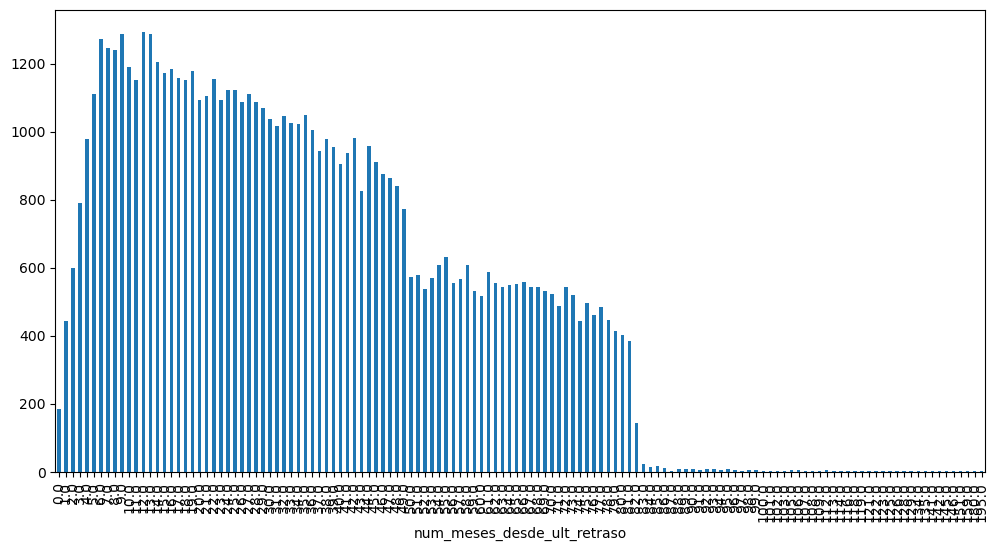

In [16]:
num.num_meses_desde_ult_retraso.value_counts().sort_index().plot.bar(figsize=(12, 6))
plt.show()

There are few records with 0 months late, so impute null values with the value zero.

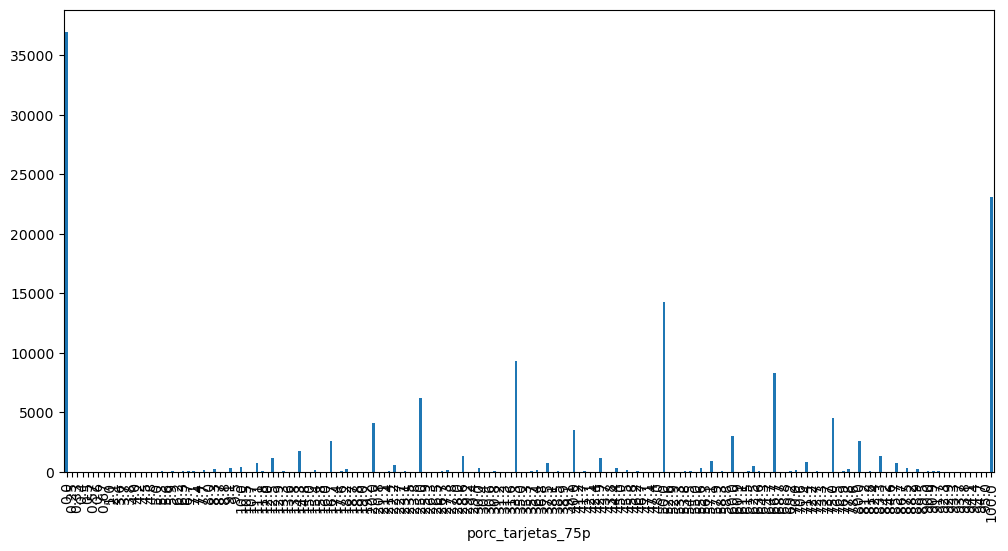

In [17]:
num.porc_tarjetas_75p.value_counts().sort_index().plot.bar(figsize=(12, 6))
plt.show()

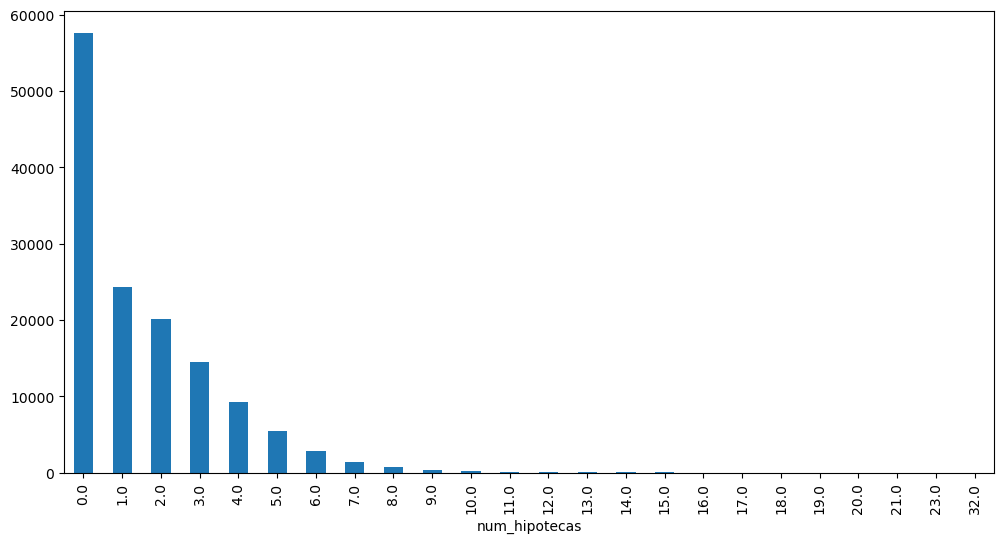

In [18]:
num.num_hipotecas.value_counts().sort_index().plot.bar(figsize=(12, 6))
plt.show()

In [19]:
num.porc_uso_revolving.value_counts()

porc_uso_revolving
0.00      812
56.00     289
48.00     282
63.00     274
55.00     268
         ... 
109.90      1
105.00      1
106.80      1
113.70      1
118.30      1
Name: count, Length: 1097, dtype: int64

In [20]:
num.dti.value_counts()

dti
0.00     110
15.60    103
18.00     97
12.00     97
16.80     93
        ... 
42.82      1
47.27      1
71.62      1
46.77      1
73.21      1
Name: count, Length: 5284, dtype: int64

In [21]:
num.num_cancelaciones_12meses.value_counts()

num_cancelaciones_12meses
0.00    138934
1.00       976
2.00        62
3.00        12
5.00         3
4.00         3
Name: count, dtype: int64

In [22]:
num.num_lineas_credito.value_counts()

num_lineas_credito
9.00     12273
10.00    11750
8.00     11518
11.00    10966
7.00     10742
         ...  
53.00        1
80.00        1
63.00        1
59.00        1
69.00        1
Name: count, Length: 63, dtype: int64

In [23]:
num.num_derogatorios.value_counts()

num_derogatorios
0.00     117677
1.00      19000
2.00       2162
3.00        688
4.00        230
5.00        115
6.00         55
7.00         25
8.00         16
9.00         13
10.00         6
13.00         3
19.00         2
11.00         2
31.00         1
15.00         1
46.00         1
Name: count, dtype: int64

Conclusions:

* The majority category is zero. Impute by zero.

In [24]:
num = num.fillna(0)

##### Outliers values

Build function to find outliers of a variable

In [25]:
def outliers_std(variable, num_std=4):
    """Get the indexes of the outlier values of a variable based
     in the number of standard deviations"""
    not_null_variable = variable.dropna()
    
    media = np.mean(not_null_variable)
    std = np.std(not_null_variable)
    umbral = std * num_std
    lim_inf = media - umbral
    lim_sup = media + umbral
    outliers_indexes = variable[(variable < lim_inf) | (variable > lim_sup)].index
    
    return outliers_indexes

def count_outliers(df, variable, num_std=4):
    outliers = outliers_std(df[variable], num_std)
    return df.loc[outliers, variable].value_counts()

In [26]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140000 entries, 4798121 to 94394801
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ingresos                     140000 non-null  float64
 1   dti                          140000 non-null  float64
 2   num_hipotecas                140000 non-null  float64
 3   num_lineas_credito           140000 non-null  float64
 4   porc_tarjetas_75p            140000 non-null  float64
 5   porc_uso_revolving           140000 non-null  float64
 6   num_cancelaciones_12meses    140000 non-null  float64
 7   num_derogatorios             140000 non-null  float64
 8   num_meses_desde_ult_retraso  140000 non-null  float64
 9   principal                    140000 non-null  float64
 10  tipo_interes                 140000 non-null  float64
 11  imp_cuota                    140000 non-null  float64
 12  imp_amortizado               140000 non-null  float64
 

In [27]:
vars_outliers = [
    'ingresos', 'principal', 'imp_cuota', 'imp_recuperado',
    'dti', 'porc_uso_revolving'
]
for variable in vars_outliers:
    print('\n' + variable + ':\n')
    print(count_outliers(num, variable, 4))


ingresos:

ingresos
400,000.00      99
500,000.00      43
450,000.00      42
600,000.00      17
550,000.00      15
                ..
505,000.00       1
564,000.00       1
3,437,892.00     1
710,000.00       1
445,000.00       1
Name: count, Length: 160, dtype: int64

principal:

Series([], Name: count, dtype: int64)

imp_cuota:

imp_cuota
1,714.54    1
1,566.80    1
1,587.02    1
Name: count, dtype: int64

imp_recuperado:

imp_recuperado
4,000.00     6
3,600.00     5
6,000.00     3
11,000.00    3
3,200.00     3
            ..
9,577.26     1
3,238.15     1
4,661.60     1
6,140.91     1
3,676.27     1
Name: count, Length: 1593, dtype: int64

dti:

dti
999.00    11
83.31      2
79.34      2
80.40      2
95.97      2
          ..
396.20     1
79.83      1
165.00     1
98.56      1
102.30     1
Name: count, Length: 256, dtype: int64

porc_uso_revolving:

porc_uso_revolving
155.30    1
366.60    1
158.70    1
Name: count, dtype: int64


Review the income variable

In [28]:
num.ingresos.describe()

count     140,000.00
mean       78,221.63
std        80,102.20
min             0.00
25%        46,000.00
50%        65,000.00
75%        93,000.00
max     9,573,072.00
Name: ingresos, dtype: float64

Review dti variable

In [29]:
num.dti.describe()

count   140,000.00
mean         18.81
std          14.95
min          -1.00
25%          11.90
50%          17.77
75%          24.45
max         999.00
Name: dti, dtype: float64

Review porc_uso_revolving variable

In [30]:
num.porc_uso_revolving.describe()

count   140,000.00
mean         50.24
std          24.70
min           0.00
25%          31.50
50%          50.20
75%          69.20
max         366.60
Name: porc_uso_revolving, dtype: float64

Delete the records with income greater than $300,000

In [31]:
to_eliminate = num.loc[num.ingresos > 300_000].index.values
to_eliminate[0:10]

array([ 97629676, 115087816,  88149047,  70180828,  83678168,  57316403,
        55380417,  60525500,  26329813, 114093587])

In [32]:
num = num[~num.index.isin(to_eliminate)]
cat = cat[~cat.index.isin(to_eliminate)]

Set limits on dti, porc_uso_revolving variables

In [33]:
num['dti'] = num['dti'].clip(0, 100)
num['porc_uso_revolving'] = num['porc_uso_revolving'].clip(0, 100)

#### Save datasets

In [34]:
work.to_pickle('../data/work_quality.pickle')
num.to_pickle('../data/num_quality.pickle')
cat.to_pickle('../data/cat_quality.pickle')

### Exploratory data analysis

##### Load data

In [35]:
num = pd.read_pickle('../data/num_quality.pickle')
cat = pd.read_pickle('../data/cat_quality.pickle')

#### EDA Categorical

##### Statistic analysis

In [36]:
def get_cat_frequency(df_cat):
    df_cat = df_cat.astype(str)
    result = (
        df_cat.apply(lambda x: x.value_counts(normalize=True))
        .T
        .stack()
        .reset_index()
        .rename(columns={"level_0": "Variable", "level_1": "Value", 0: "Frequency"})
        .sort_values(by=["Variable", "Frequency"])
    )
    return result

In [37]:
variables = [
    'antigüedad_empleo', 'ingresos_verificados', 'rating',
    'vivienda','finalidad', 'num_cuotas', 'estado'
]
get_cat_frequency(cat[variables])

,Variable,Value,Frequency
9,antigüedad_empleo,9 years,0.03
8,antigüedad_empleo,8 years,0.04
7,antigüedad_empleo,7 years,0.04
6,antigüedad_empleo,6 years,0.05
4,antigüedad_empleo,4 years,0.06
5,antigüedad_empleo,5 years,0.06
11,antigüedad_empleo,unknown,0.06
0,antigüedad_empleo,1 year,0.07
3,antigüedad_empleo,3 years,0.08
10,antigüedad_empleo,< 1 year,0.09


##### Graphic analysis

In [38]:
def graph_eda_categorical(cat):
    
    from math import ceil
    rows = ceil(cat.shape[1] / 2)

    #Graph each variable
    f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(16, rows * 6))
    ax = ax.flat 
    for index, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax=ax[index])
        ax[index].set_title(variable, fontsize=12, fontweight="bold")
        ax[index].tick_params(labelsize=12)

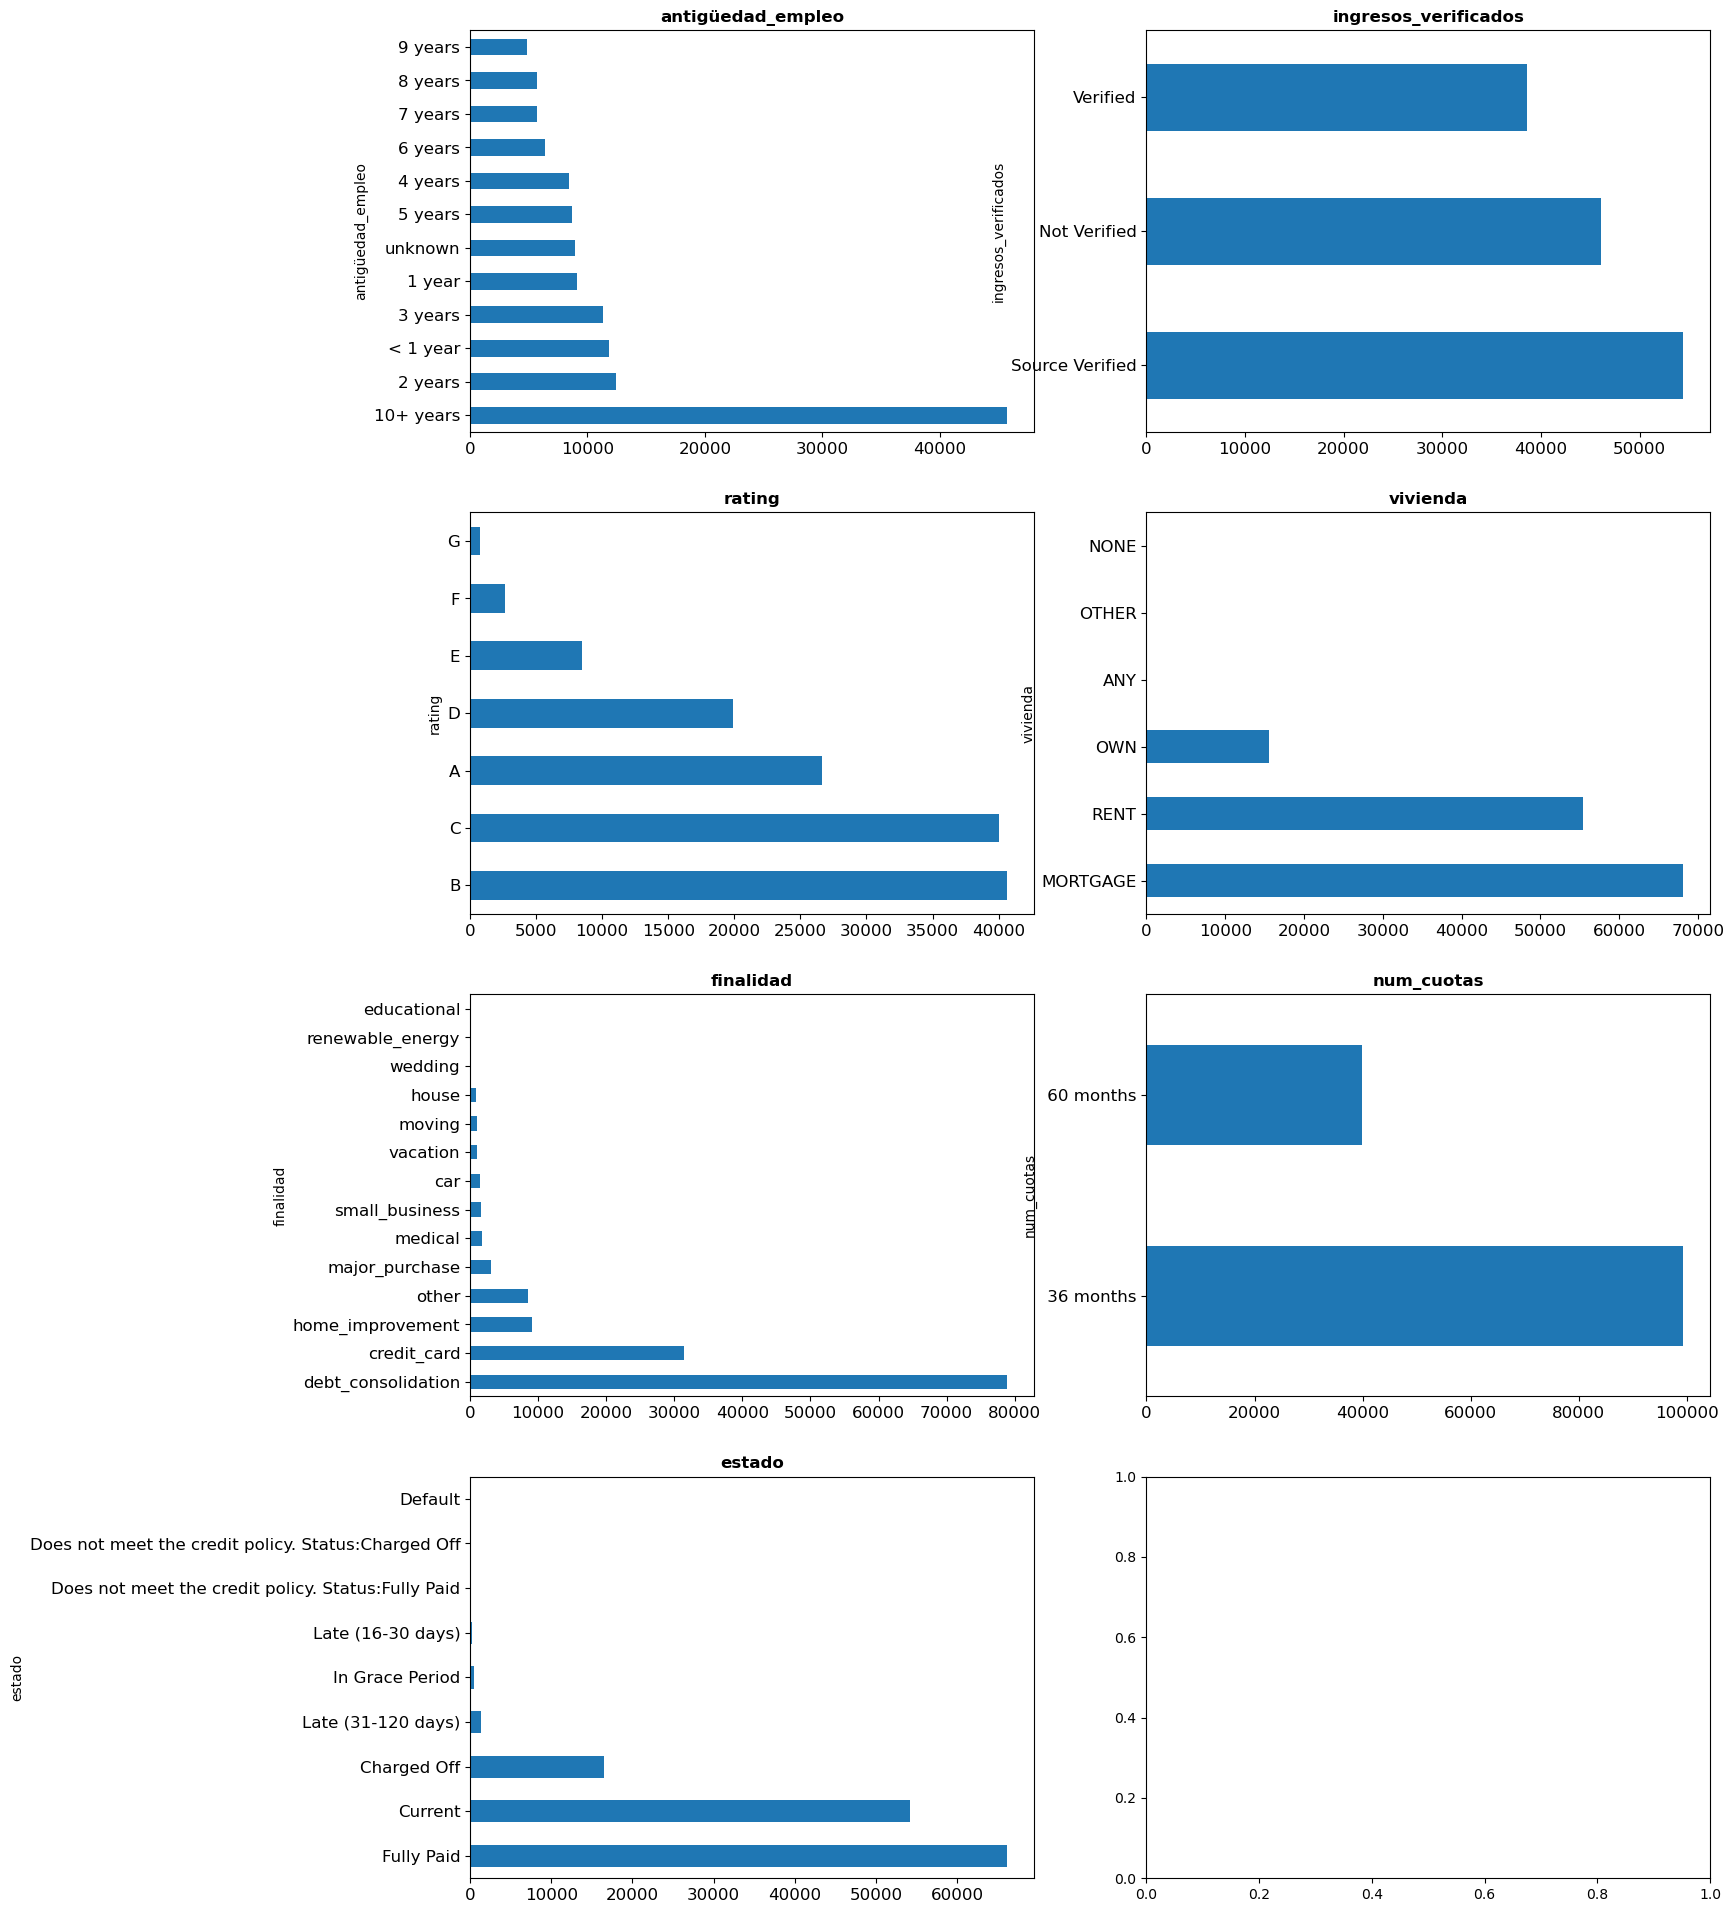

In [39]:
graph_eda_categorical(cat[variables])

Conclusions:
* vivienda variable: replace the categories (NONE, OTHER, ANY) to the majority category.
* finalidad variable: replace the categories (educational, reneweable_energy, wedding) in 'others'
* Generate the target variable based on the "estado" variable

#### EDA Numeric

##### Statistic analysis

In [40]:
num.describe().T

,count,mean,std,min,25%,50%,75%,max
ingresos,"139,072.00","75,155.98","42,433.97",0.00,"46,000.00","65,000.00","92,000.00","300,000.00"
dti,"139,072.00",18.69,9.68,0.00,11.98,17.84,24.50,100.00
num_hipotecas,"139,072.00",1.51,1.88,0.00,0.00,1.00,2.00,32.00
num_lineas_credito,"139,072.00",11.62,5.63,0.00,8.00,11.00,14.00,91.00
porc_tarjetas_75p,"139,072.00",41.00,36.38,0.00,0.00,33.30,66.70,100.00
porc_uso_revolving,"139,072.00",50.22,24.64,0.00,31.60,50.20,69.20,100.00
num_cancelaciones_12meses,"139,072.00",0.01,0.10,0.00,0.00,0.00,0.00,5.00
num_derogatorios,"139,072.00",0.20,0.56,0.00,0.00,0.00,0.00,46.00
num_meses_desde_ult_retraso,"139,072.00",16.82,23.04,0.00,0.00,0.00,31.00,195.00
principal,"139,072.00","14,988.06","9,143.76",600.00,"8,000.00","12,800.00","20,000.00","40,000.00"


##### Graph analysis

In [41]:
def graph_eda_numeric(num):
    
    from math import ceil
    rows = ceil(num.shape[1] / 2)
    #Graph each variable
    f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(16, rows * 6))
    ax = ax.flat 
    for index, variable in enumerate(num):
        num[variable].plot.density(ax=ax[index])
        ax[index].set_title(variable, fontsize=12, fontweight="bold")
        ax[index].tick_params(labelsize=12)

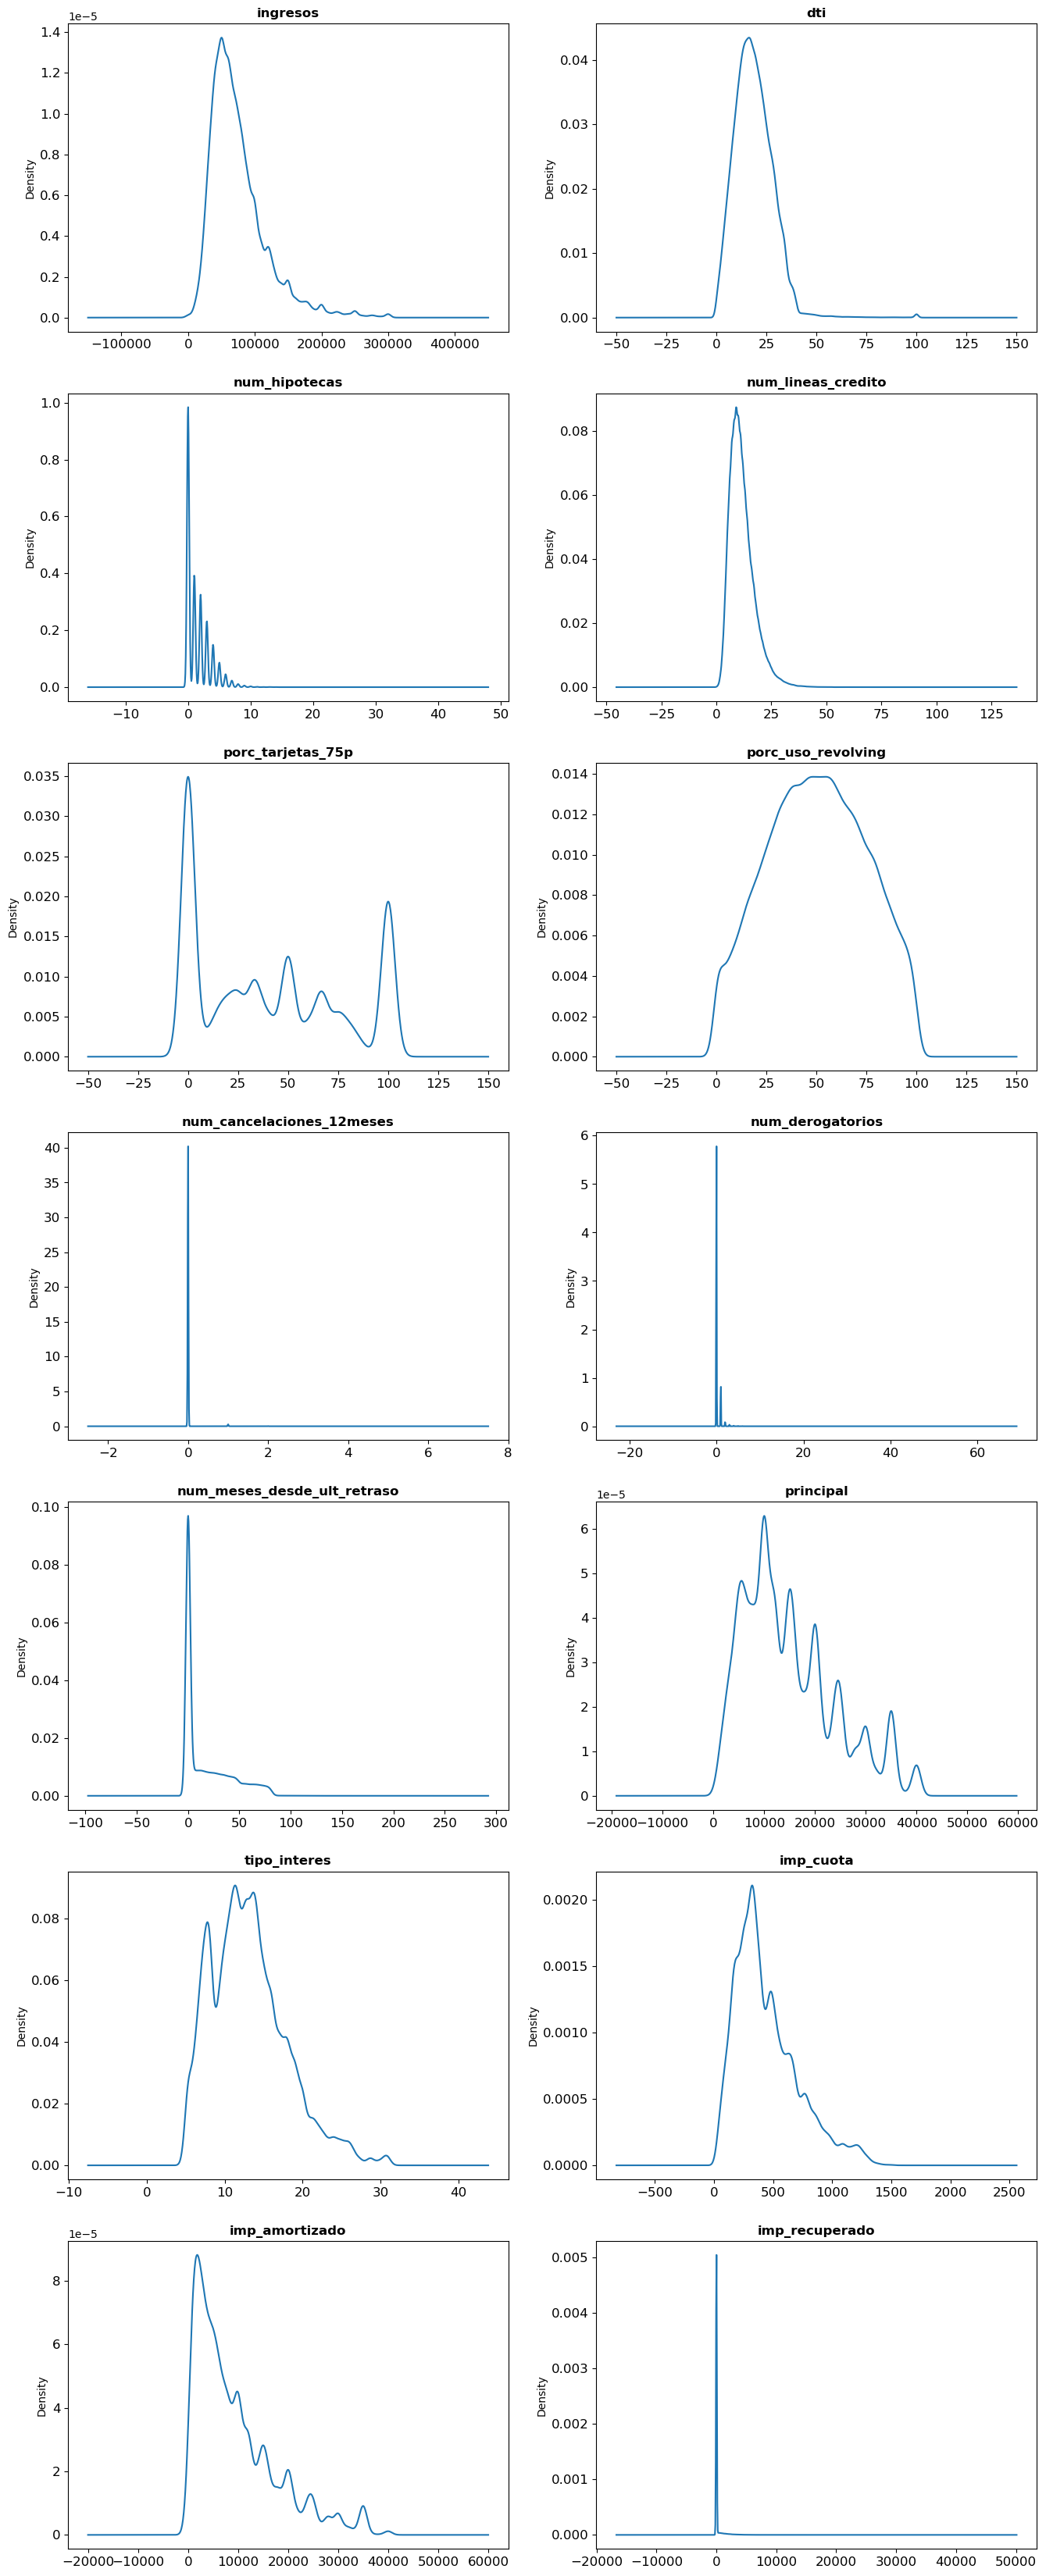

In [42]:
graph_eda_numeric(num)

Analyze the details of the variables: imp_amortizado, imp_recuperado, since they are relevant to the target of the LGD model.

In [43]:
ratios = num[['principal','imp_amortizado','imp_recuperado']].copy()
ratios['r_amortizado_principal'] = ratios.imp_amortizado / ratios.principal
ratios['r_recuperado_principal'] = ratios.imp_recuperado / ratios.principal
ratios.describe().T

,count,mean,std,min,25%,50%,75%,max
principal,"139,072.00","14,988.06","9,143.76",600.00,"8,000.00","12,800.00","20,000.00","40,000.00"
imp_amortizado,"139,072.00","9,465.74","8,265.09",0.00,"3,000.00","7,000.00","13,728.55","40,000.00"
imp_recuperado,"139,072.00",144.61,759.37,0.00,0.00,0.00,0.00,"33,407.16"
r_amortizado_principal,"139,072.00",0.66,0.37,0.00,0.27,0.87,1.00,1.00
r_recuperado_principal,"139,072.00",0.01,0.04,0.00,0.00,0.00,0.00,1.06


Conclusions:

* In the transformation stage convert the variable "num_derogatorio" to binary
* Review in depth the relationship between the variables "estado" and "imp_recuperado"

In [44]:
temp = cat[['estado']].merge(num[['imp_recuperado']], left_index=True, right_index=True)
temp.groupby('estado').imp_recuperado.mean()

estado
Charged Off                                           1,215.28
Current                                                   0.00
Default                                                   0.00
Does not meet the credit policy. Status:Charged Off     414.25
Does not meet the credit policy. Status:Fully Paid        0.00
Fully Paid                                                0.00
In Grace Period                                           0.00
Late (16-30 days)                                         0.00
Late (31-120 days)                                        0.00
Name: imp_recuperado, dtype: float64

#### Save datasets

In [47]:
num.to_pickle('../data/num_result_eda.pickle')
cat.to_pickle('../data/cat_result_eda.pickle')

### Transform variables

#### Load data

In [3]:
num = pd.read_pickle('../data/num_result_eda.pickle')
cat = pd.read_pickle('../data/cat_result_eda.pickle')

#### Generate variables

##### Probability Default(PD)

In [4]:
cat.estado.value_counts()

estado
Fully Paid                                             66092
Current                                                54136
Charged Off                                            16529
Late (31-120 days)                                      1345
In Grace Period                                          519
Late (16-30 days)                                        273
Does not meet the credit policy. Status:Fully Paid       117
Does not meet the credit policy. Status:Charged Off       58
Default                                                    3
Name: count, dtype: int64

In [7]:
default = ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default']
cat['target_pd'] = np.where(cat.estado.isin(default), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,unknown,debt_consolidation,36 months,Charged Off,1
46641215,Banker,5 years,Verified,A,RENT,unknown,debt_consolidation,36 months,Fully Paid,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,unknown,credit_card,60 months,Current,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,unknown,debt_consolidation,36 months,Fully Paid,0
131289518,unknown,10+ years,Source Verified,D,MORTGAGE,unknown,home_improvement,60 months,Current,0
...,...,...,...,...,...,...,...,...,...,...
51876926,Office Manager,10+ years,Not Verified,C,MORTGAGE,unknown,debt_consolidation,36 months,Fully Paid,0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,unknown,other,36 months,Current,0
135641397,Sr. Field Engineer,10+ years,Source Verified,D,MORTGAGE,unknown,small_business,36 months,Current,0


In [11]:
cat = cat.drop(columns='estado')

##### Exposure at Default(EAD)

Percentage of the principal amount not amortized at the time of default

In [13]:
num['pendiente'] = num.principal - num.imp_amortizado
num.head()

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
4798121,"65,000.00",25.40,1.00,15.00,85.70,86.20,0.00,0.00,0.00,"10,000.00",17.77,360.38,"6,362.96",0.00,"3,637.04"
46641215,"135,000.00",14.68,0.00,19.00,0.00,16.30,0.00,0.00,0.00,"24,000.00",6.39,734.38,"24,000.00",0.00,0.00
87998444,"188,000.00",11.69,3.00,15.00,0.00,3.30,0.00,0.00,0.00,"27,000.00",8.99,560.35,"12,443.00",0.00,"14,557.00"
132883631,"125,000.00",9.00,1.00,6.00,33.30,69.90,0.00,0.00,16.00,"22,000.00",10.90,719.22,"22,000.00",0.00,0.00
131289518,"72,777.00",24.74,2.00,10.00,33.30,63.20,0.00,0.00,0.00,"25,000.00",21.85,688.35,"2,811.27",0.00,"22,188.73"


In [15]:
num['target_ead'] = num.pendiente / num.principal
num.head()

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
4798121,"65,000.00",25.40,1.00,15.00,85.70,86.20,0.00,0.00,0.00,"10,000.00",17.77,360.38,"6,362.96",0.00,"3,637.04",0.36
46641215,"135,000.00",14.68,0.00,19.00,0.00,16.30,0.00,0.00,0.00,"24,000.00",6.39,734.38,"24,000.00",0.00,0.00,0.00
87998444,"188,000.00",11.69,3.00,15.00,0.00,3.30,0.00,0.00,0.00,"27,000.00",8.99,560.35,"12,443.00",0.00,"14,557.00",0.54
132883631,"125,000.00",9.00,1.00,6.00,33.30,69.90,0.00,0.00,16.00,"22,000.00",10.90,719.22,"22,000.00",0.00,0.00,0.00
131289518,"72,777.00",24.74,2.00,10.00,33.30,63.20,0.00,0.00,0.00,"25,000.00",21.85,688.35,"2,811.27",0.00,"22,188.73",0.89


##### Loss Given Default(LGD)

Pending percentage not recovered in case of non-payment

In [23]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num['target_lgd'] = num['target_lgd'].fillna(0)
num.head()

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
4798121,"65,000.00",25.40,1.00,15.00,85.70,86.20,0.00,0.00,0.00,"10,000.00",17.77,360.38,"6,362.96",0.00,"3,637.04",0.36,1.00
46641215,"135,000.00",14.68,0.00,19.00,0.00,16.30,0.00,0.00,0.00,"24,000.00",6.39,734.38,"24,000.00",0.00,0.00,0.00,0.00
87998444,"188,000.00",11.69,3.00,15.00,0.00,3.30,0.00,0.00,0.00,"27,000.00",8.99,560.35,"12,443.00",0.00,"14,557.00",0.54,1.00
132883631,"125,000.00",9.00,1.00,6.00,33.30,69.90,0.00,0.00,16.00,"22,000.00",10.90,719.22,"22,000.00",0.00,0.00,0.00,0.00
131289518,"72,777.00",24.74,2.00,10.00,33.30,63.20,0.00,0.00,0.00,"25,000.00",21.85,688.35,"2,811.27",0.00,"22,188.73",0.89,1.00


In [26]:
cat['target_pd'].mean() * 100

11.929072710538426

In [28]:
num[['target_ead', 'target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,"139,072.00",0.34,0.37,-0.00,0.00,0.13,0.73,1.00
target_lgd,"139,072.00",0.51,0.49,-0.26,0.00,0.85,1.00,1.00


In [29]:
num['target_ead'] = np.where(num.target_ead < 0, 0, num.target_ead)
num['target_ead'] = np.where(num.target_ead > 1, 1, num.target_ead)
num['target_lgd'] = np.where(num.target_lgd < 0, 0, num.target_lgd)
num['target_lgd'] = np.where(num.target_lgd > 1, 1, num.target_lgd)

Delete num_meses_desde_ult_retraso variable

In [31]:
num = num.drop(columns='num_meses_desde_ult_retraso')

##### vivienda variable

Unite categories: ANY, NONE, OTHER

In [32]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68110
RENT        55360
OWN         15524
ANY            63
OTHER          12
NONE            3
Name: count, dtype: int64

In [33]:
cat['vivienda'] = cat.vivienda.replace(['ANY', 'NONE', 'OTHER'], 'MORTGAGE')

In [34]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68188
RENT        55360
OWN         15524
Name: count, dtype: int64

##### finalidad variable

Replace categories: educational, reneweable_energy, wedding into 'others'

In [35]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    78849
credit_card           31469
home_improvement       9123
other                  8548
major_purchase         3118
medical                1688
small_business         1619
car                    1443
vacation               1015
moving                 1007
house                   941
wedding                 143
renewable_energy         89
educational              20
Name: count, dtype: int64

In [36]:
cat['finalidad'] = cat.finalidad.replace(['educational', 'reneweable_energy', 'wedding'], 'others')
cat.finalidad.value_counts()

finalidad
debt_consolidation    78849
credit_card           31469
home_improvement       9123
other                  8548
major_purchase         3118
medical                1688
small_business         1619
car                    1443
vacation               1015
moving                 1007
house                   941
others                  163
renewable_energy         89
Name: count, dtype: int64

#### Transformar variables categóricas

##### OneHotEncodig

In [52]:
var_ohe = [ 'ingresos_verificados', 'vivienda', 'finalidad', 'num_cuotas']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_ohe = ohe.fit_transform(cat[var_ohe])
cat_ohe = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())

##### OrdinalEncoding

In [60]:
var_oe = ['antigüedad_empleo', 'rating']
order_length_employment = [
    'unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years',
    '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years', 
]
order_rating = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

oe = OrdinalEncoder(
    categories=[order_length_employment, order_rating],
    handle_unknown='use_encoded_value',
    unknown_value=12
)
cat_oe = oe.fit_transform(cat[var_oe])
names_oe = [variable + '_oe' for variable in var_oe]
cat_oe = pd.DataFrame(cat_oe, columns=names_oe)

#### Transformar variables numéricas

##### Binarizer

In [103]:
var_bin = ['num_derogatorios']
binarizer = Binarizer(threshold=0)
num_bin = binarizer.fit_transform(num[var_bin])
names_bin = [variable + '_bin' for variable in var_bin]
num_bin = pd.DataFrame(num_bin, columns=names_bin)

##### Min-Max scaler

Select variables

In [104]:
num_scaler = num[[
    'ingresos',
    'dti',
    'num_lineas_credito',
    'porc_uso_revolving',
    'principal',
    'tipo_interes',
    'imp_cuota'
]].reset_index(drop=True)
df_scaler = pd.concat([cat_oe, num_scaler], axis=1)
var_mms = df_scaler.columns

Train and apply

In [105]:
mms = MinMaxScaler()
df_mms = mms.fit_transform(df_scaler[var_mms])
names_mms = [variable + '_mms' for variable in var_mms]
df_mms = pd.DataFrame(df_mms, columns=names_mms)

#### Preparar datasets

##### Probability Default(PD) datamart

In [127]:
include_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]
datamart_pd = pd.concat(include_pd, axis=1).set_index('id_cliente')

##### Exposure at Default(EAD) datamart

In [132]:
include_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente', 'target_ead']]]
datamart_ead = pd.concat(include_ead, axis=1).set_index('id_cliente')

##### Loss Given Default(LGD) datamart

In [133]:
include_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente', 'target_lgd']]]
datamart_lgd = pd.concat(include_lgd, axis=1).set_index('id_cliente')

### Save training dataset

In [137]:
datamart_pd.to_pickle('../data/datamart_pd.pickle')
datamart_ead.to_pickle('../data/datamart_ead.pickle')
datamart_lgd.to_pickle('../data/datamart_lgd.pickle')